In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")

# Localisation du fichier CSV
current_dir = Path().resolve()
project_root = current_dir.parent
data_path = project_root / "Data" / "Dataset of weighing station temperature measurements.csv"

print("Fichier CSV :", data_path)

# IMPORTANT : le fichier est séparé par des ';'
df = pd.read_csv(data_path, sep=";")

# Aperçu
display(df.head())
print(df.columns)


In [ ]:
# On convertit la colonne Time en datetime et on la met en index
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time').sort_index()

df.head()


In [ ]:
# Colonnes de température à l'intérieur du puits
low_cols = [c for c in df.columns if "Low" in c]
mid_cols = [c for c in df.columns if "Mid" in c]
top_cols = [c for c in df.columns if "Top" in c]

# On les trie par numéro de capteur S1, S2, ... S29
def sort_by_sensor(col_list):
    return sorted(col_list, key=lambda x: int(x.split("-S")[1]))

low_cols = sort_by_sensor(low_cols)
mid_cols = sort_by_sensor(mid_cols)
top_cols = sort_by_sensor(top_cols)

print("Nb capteurs LOW :", len(low_cols))
print("Nb capteurs MID :", len(mid_cols))
print("Nb capteurs TOP :", len(top_cols))

print("\nExemples LOW :", low_cols[:5])
print("Exemples MID :", mid_cols[:5])
print("Exemples TOP :", top_cols[:5])


In [ ]:
sensor = 11  # change à 6, 10, etc. pour d'autres poteaux

col_low = low_cols[sensor-1]
col_mid = mid_cols[sensor-1]
col_top = top_cols[sensor-1]

plt.figure(figsize=(12,5))
plt.plot(df.index, df[col_low], label=f"LOW S{sensor}")
plt.plot(df.index, df[col_mid], label=f"MID S{sensor}")
plt.plot(df.index, df[col_top], label=f"TOP S{sensor}")
plt.xlabel("Temps")
plt.ylabel("Température [°C]")
plt.title(f"Température au poteau S{sensor} (LOW / MID / TOP)")
plt.legend()
plt.show()


In [ ]:
delta_z = 0.8  # m entre LOW et TOP

T_low = df[col_low]
T_top = df[col_top]

dT = T_top - T_low               # différence de température TOP - LOW [°C]
grad = dT / delta_z              # gradient vertical [°C/m]

plt.figure(figsize=(12,4))
plt.plot(df.index, grad)
plt.axhline(0, linestyle='--', color='black')
plt.xlabel("Temps")
plt.ylabel("Gradient (TOP-LOW)/0.8 [°C/m]")
plt.title(f"Gradient vertical de température au poteau S{sensor}")
plt.show()


In [ ]:
# ΔT TOP-LOW pour tous les poteaux (S1 à S29)
dT_all = pd.DataFrame({
    f"S{i+1}": df[top_cols[i]] - df[low_cols[i]]
    for i in range(29)
})

grad_all = dT_all / delta_z  # [°C/m]

# Gradient moyen par poteau
mean_grad_per_sensor = grad_all.mean()
overall_mean_grad = grad_all.stack().mean()

print("Gradient moyen par poteau [°C/m]:\n", mean_grad_per_sensor)
print("\nGradient moyen global [°C/m]:", overall_mean_grad)


In [ ]:
threshold = 1.5  # °C

is_stratified = dT_all > threshold  # DataFrame booléen

# Fraction du temps stratifié par poteau
frac_time_per_sensor = is_stratified.mean()

# Fraction du temps où au moins un poteau est stratifié
frac_time_any_sensor = is_stratified.any(axis=1).mean()

print("Fraction du temps stratifié par poteau:\n", frac_time_per_sensor)
print("\nFraction du temps où au moins un poteau est stratifié :", frac_time_any_sensor)


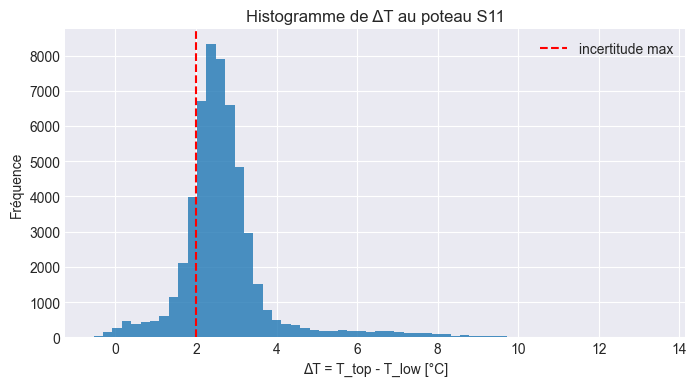

In [48]:
sensor = 11  # ton poteau près du heatgun

dT_local = dT_all[f"S{sensor}"]

plt.figure(figsize=(8,4))
plt.hist(dT_local.dropna(), bins=60, alpha=0.8)
plt.axvline(2, color='red', linestyle='--', label='incertitude max')
plt.xlabel("ΔT = T_top - T_low [°C]")
plt.ylabel("Fréquence")
plt.title(f"Histogramme de ΔT au poteau S{sensor}")
plt.legend()
plt.show()
